Augmentor is being used to supplement the training data with variations of the images.

In [1]:
# import data set, standardise and create new samples
# un-comment this block to create data set samples

# import sys
# import Augmentor
# folder_path="./data/raw-data-energy-meters/no-meter-readings-raw/"
# p = Augmentor.Pipeline(source_directory=folder_path, save_format="JPEG")
# p.flip_left_right(0.5)
# p.black_and_white(0.1)
# p.rotate(0.3, 10, 10)
# p.skew(0.4, 0.5)
# p.skew_tilt(0.6, 0.8)
# p.skew_left_right(0.5, magnitude=0.8)
# p.sample(1000)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import pickle
import random
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from keras.callbacks import TensorBoard
import time

Using TensorFlow backend.


Set all variations of the model

In [3]:
dense_layers = [0, 1, 2]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3]

In [4]:
DATADIR = './data/raw-data-energy-meters'
CATEGORIES = ['no-meter-readings', 'meter-readings']

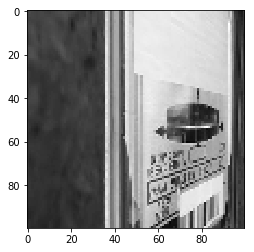

In [7]:
IMG_SIZE = 100
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [8]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()

In [10]:
random.shuffle(training_data)

In [11]:
for sample in training_data[:10]:
    print(sample[1])

1
1
0
1
1
0
0
0
0
1


In [12]:
X = []
y = []

In [13]:
for features, label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [14]:
# save data manipulation

pickle_out = open("04_energy_meters_recognition_cnn/X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("04_energy_meters_recognition_cnn/y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [15]:
pickle_in = open("04_energy_meters_recognition_cnn/X.pickle", "rb")
X = pickle.load(pickle_in)

In [16]:
pickle_in = open("04_energy_meters_recognition_cnn/y.pickle", "rb")
y = pickle.load(pickle_in)

In [17]:
X = X/255

In [18]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
            
            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape = X.shape[1:]))
            model.add(Activation("relu"))
            model.add(MaxPool2D(pool_size=(2,2)))
            
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3), input_shape = X.shape[1:]))
                model.add(Activation("relu"))
                model.add(MaxPool2D(pool_size=(2,2)))

            model.add(Flatten())

            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
                        
            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])


            model.fit(X, y, batch_size=32, epochs=20, validation_split=0.1, callbacks=[tensorboard])

model.save('04_energy_meters_recognition_cnn/model_energy_meter.model')

Train on 1800 samples, validate on 200 samples
Epoch 1/20
1800/1800 [==============================] - 9s 5ms/step - loss: 0.6331 - acc: 0.6506 - val_loss: 0.5664 - val_acc: 0.7250
Epoch 2/20
1800/1800 [==============================] - 9s 5ms/step - loss: 0.5088 - acc: 0.7694 - val_loss: 0.5614 - val_acc: 0.7150
Epoch 3/20
1800/1800 [==============================] - 9s 5ms/step - loss: 0.4626 - acc: 0.7856 - val_loss: 0.5262 - val_acc: 0.7650
Epoch 4/20
1800/1800 [==============================] - 9s 5ms/step - loss: 0.4508 - acc: 0.7983 - val_loss: 0.5284 - val_acc: 0.7750
Epoch 5/20
1800/1800 [==============================] - 9s 5ms/step - loss: 0.3823 - acc: 0.8294 - val_loss: 0.5202 - val_acc: 0.7800
Epoch 6/20
1800/1800 [==============================] - 9s 5ms/step - loss: 0.3577 - acc: 0.8600 - val_loss: 0.5287 - val_acc: 0.7800
Epoch 7/20
1800/1800 [==============================] - 9s 5ms/step - loss: 0.2926 - acc: 0.8828 - val_loss: 0.5199 - val_acc: 0.8000
Epoch 8/20
1800

This method will convert images to be used for predictions into the correct format

In [19]:
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    plt.imshow(new_array, cmap='gray')
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [20]:
model = tf.keras.models.load_model("04_energy_meters_recognition_cnn/model_energy_meter.model")

The first first prediction is being made on an image of my own energy meter which was not part of the original data train or test sample.

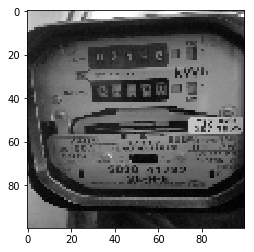

In [33]:
prediction = model.predict([prepare('./img/meter-test-1.jpg')])

In [34]:
print(CATEGORIES[int(prediction[0][0])])

meter-readings


This second prediction is being made on something I think might confuse the CNN as it contains numbers in digit form

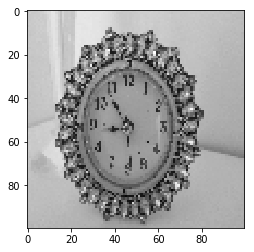

In [36]:
prediction = model.predict([prepare('./img/meter-test-2.jpg')])

In [37]:
print(CATEGORIES[int(prediction[0][0])])

no-meter-readings
